# Finding Leaked Images

This kernel aims to find images "leaked" from the training set into the Stage 1 test set (because sometimes md5sum isn't enough!)  
We will use an ImageNet trained VGG16 with FC layers removed to get bottleneck features from all images.  
We will then compute the L2 distance between test vectors and train vectors and see if we get a match.  
**Note:** Kaggle server won't allow downloading of VGG16 weights file so this notebook will need to be run locally.   


First we import all necessary libraries:

In [1]:
import future
from __future__ import print_function
import os
import glob
import sys
from tqdm import tqdm
import numpy as np
import cv2
from keras import applications
from sklearn.neighbors import KDTree
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


Define our training/test image directories. We'll only look in Type_3 additional folder for brevity:

In [8]:
TRAIN_DATA_DIR = '/mnt/disk/storage/cervical_cancer/additional_v2_clean/original/Type_3'
TEST_DATA_DIR = '/mnt/disk/storage/cervical_cancer/test'
IMG_SHAPE = (256, 256)

Next we define some utility functions which we will use later.  
(The function definitions are self-explanitory.)  

In [9]:
def array_to_txt_file(filename, arr):
    with open(filename, 'w') as f:
        for item in arr:
            f.write('{}\n'.format(str(item)))


def txt_file_to_array(filename):
    with open(filename) as f:
        content = f.readlines()
    # remove whitespace characters like `\n` at the end of each line
    array = [x.strip() for x in content]
    return array

def flatten_vectors(vectors):
    vectors_flattened = []
    for vec in vectors:
        vectors_flattened.append(vec.flatten())# flatten vectors to 1-dimension
    return np.array(vectors_flattened)

def gather_and_resize_images():
    # get train image paths and save to python list
    training_paths = glob.glob(TRAIN_DATA_DIR + '/*jpg')
    test_paths = glob.glob(TEST_DATA_DIR + '/*.jpg')
    training_images = []
    test_images = []
    training_paths_list = []
    test_paths_list = []
    print ('gathering and resizing images (may take a few minutes)...')
    for i, tp in enumerate(training_paths):
        img = cv2.imread(tp)
        if i%100 == 0:
            print ('{} of {} train images loaded'.format(i, len(training_paths)))
        if img is not None:
            img = cv2.resize(src=img, dsize=IMG_SHAPE)
            training_images.append(img)
            training_paths_list.append(tp)
    for i, tp in enumerate(test_paths):
        img = cv2.imread(tp)
        if i%100 == 0:
            print ('{} of {} test images loaded'.format(i, len(test_paths)))
        if img is not None:
            img = cv2.resize(src=img, dsize=IMG_SHAPE)
            test_images.append(img)
            test_paths_list.append(tp)
    print ('\ndone')
    # save image lists for later
    array_to_txt_file('image_paths_train.txt', training_paths_list)
    array_to_txt_file('image_paths_test.txt', test_paths_list)
    # convert lists of images to numpy arrays and save for later
    training_images = np.array(training_images)
    test_images = np.array(test_images)
    np.save(open('training_images.npy', 'wb'),
            training_images)
    np.save(open('test_images.npy', 'wb'),
            test_images)
    print ('training_images shape: {}'.format(training_images.shape))
    print ('test_images shape: {}'.format(test_images.shape))
    

Iterate through the training / test folders and save all images into numpy arrays.  
We will `np.save()`the arrays so we only have to run this code once.   
(This will take a few minutes)  

In [10]:
gather_and_resize_images()

gathering and resizing images (may take a few minutes)...
0 of 1542 train images loaded
100 of 1542 train images loaded
200 of 1542 train images loaded
300 of 1542 train images loaded
400 of 1542 train images loaded
500 of 1542 train images loaded
600 of 1542 train images loaded
700 of 1542 train images loaded
800 of 1542 train images loaded
900 of 1542 train images loaded
1000 of 1542 train images loaded
1100 of 1542 train images loaded
1200 of 1542 train images loaded
1300 of 1542 train images loaded
1400 of 1542 train images loaded
1500 of 1542 train images loaded
0 of 512 test images loaded
100 of 512 test images loaded
200 of 512 test images loaded
300 of 512 test images loaded
400 of 512 test images loaded
500 of 512 test images loaded

done
training_images shape: (1542, 256, 256, 3)
test_images shape: (512, 256, 256, 3)


Next we define the "headless" VGG16 which we will use to extract bottleneck features from all images in train and test sets.  
We will `np.save()` the arrays so we only have to run this code once.  

In [11]:
def save_bottlebeck_features():
    gen_features_batch_size = 1  # use 1 so that we don't miss any images if dataset not divisible by this number
    # normalize image input
    datagen = ImageDataGenerator(rescale=1. / 255)
    # build a headless VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    # load image paths and data
    training_paths_list = txt_file_to_array('image_paths_train.txt')
    test_paths_list = txt_file_to_array('image_paths_test.txt')
    nb_train_samples = len(training_paths_list)
    nb_test_samples = len(test_paths_list)
    training_images = np.load('training_images.npy')
    test_images = np.load('test_images.npy')

    print ('generating bottleneck features...')
    # create generator for training data
    # Note: shuffle=False so we can keep track of which filename belongs to each vector
    train_generator = datagen.flow(
        x=np.array(training_images),
        batch_size=gen_features_batch_size,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        train_generator, nb_train_samples // gen_features_batch_size,
        verbose=1)
    test_generator = datagen.flow(
        x=np.array(test_images),
        batch_size=gen_features_batch_size,
        shuffle=False)
    bottleneck_features_test = model.predict_generator(
        test_generator, nb_test_samples // gen_features_batch_size,
        verbose=1)
    np.save(open('bottleneck_features_train.npy', 'w'),
            bottleneck_features_train)
    np.save(open('bottleneck_features_test.npy', 'w'),
            bottleneck_features_test)
    print ('\ndone')

In [13]:
save_bottlebeck_features()

generating bottleneck features...
509/512 [============================>.] - ETA: 0s
done


Now that we have our train/test bottleneck features, we can flatten them to 1D and perform a K-Nearest-Neighbours search for each test vector vs. all training vectors.  
For brevity, we will only look at the first 30 matches out of 512.  

In [18]:
def find_duplicates():
    max_display_num = 30 # display this many matches (max=512)
    # load image lists
    train_image_list = txt_file_to_array(filename='./image_paths_train.txt')
    test_image_list = txt_file_to_array(filename='./image_paths_test.txt')
    # load training and test vectors
    train_vectors = np.load('./bottleneck_features_train.npy')
    test_vectors = np.load('./bottleneck_features_test.npy')
    # flatten vectors so each is 1 dimensional
    train_vectors = flatten_vectors(train_vectors)
    test_vectors = flatten_vectors(test_vectors)
    # load train vectors into KDTree
    kd = KDTree(train_vectors, leaf_size=40, metric='euclidean')
    # find K closest vectors to each test vector
    k = 3
    # compare test/train vectors to find duplicates
    # note we could also find all distances and indices in one shot with kd.query(X=test_vectors)
    print ('beginning KNN search...')
    for i, test_vector in enumerate(test_vectors):
        if i > max_display_num:
            break
        dists, indices = kd.query(X=test_vector.reshape(1, -1), k=k, return_distance=True)
        dists = dists[0]
        indices = indices[0]
        test_img_path = test_image_list[i]
        test_img = cv2.imread(test_img_path)
        test_img = cv2.resize(test_img, (256, 256))  # resize for display
        plt.subplot(1, k + 1, 1)  # plot query image
        plt.title('query image')
        plt.axis('off')
        test_filename = os.path.basename(test_img_path)
        cv2.putText(test_img, test_filename, (0, 25), 1, 1.75, (0, 0, 255), 2)
        plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
        for j, ind in enumerate(indices):
            distance = dists[j]
            train_img_path = train_image_list[ind]
            train_img = cv2.imread(train_img_path)
            train_img = cv2.resize(train_img, (256, 256))  # resize for display
            train_filename = os.path.basename(train_img_path)
            train_class_type = os.path.basename(os.path.dirname(train_img_path))
            # write some useful text on each image (filename, distance, class type)
            cv2.putText(train_img, train_filename, (0, 25), 1, 1.75, (0, 255, 0), 2)
            cv2.putText(train_img, 'dist={}'.format(distance), (0, 50), 1, 1.75, (0, 255, 0), 2)
            cv2.putText(train_img, train_class_type, (0, 75), 1, 1.75, (0, 255, 0), 2)
            plt.subplot(1, k + 1, j + 2)  # plot result image
            plt.title('{}'.format(j + 1))
            plt.axis('off')
            plt.imshow(cv2.cvtColor(train_img, cv2.COLOR_BGR2RGB))
        plt.show()
    print ('done.')

beginning KNN search...


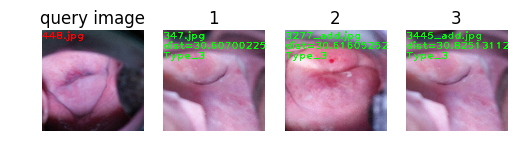

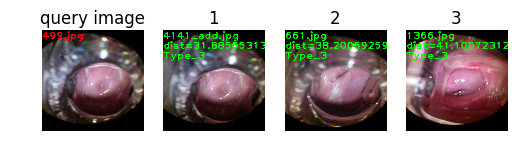

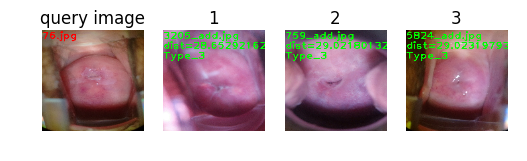

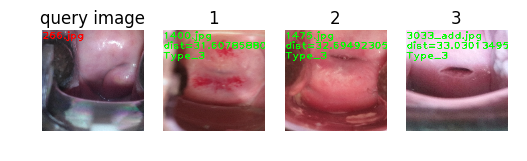

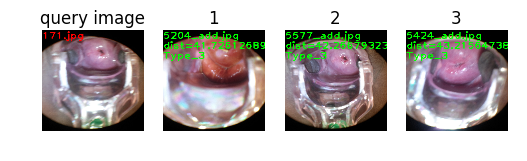

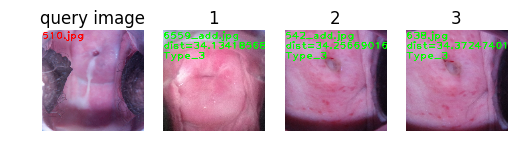

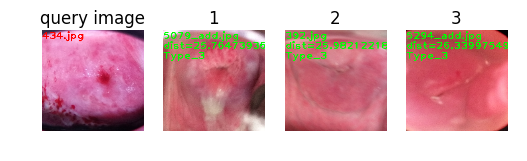

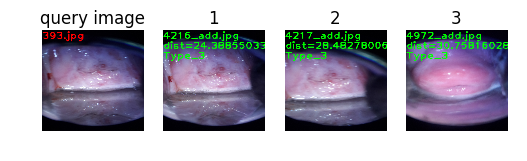

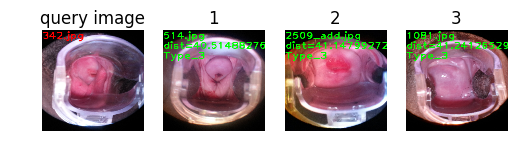

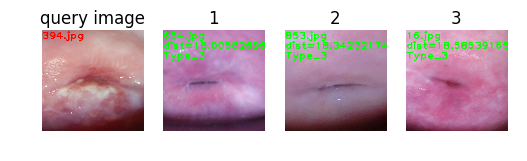

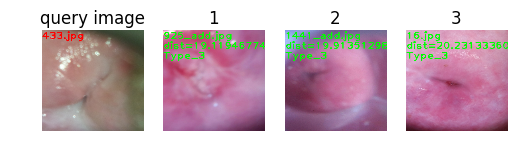

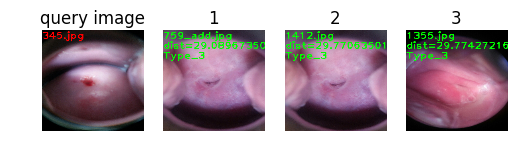

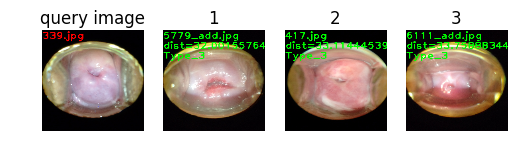

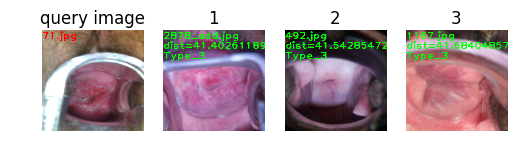

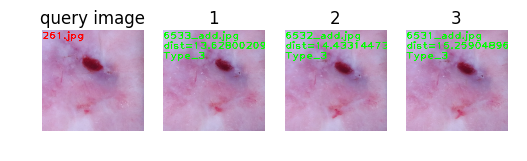

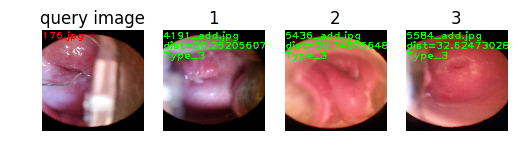

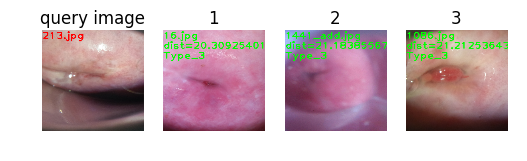

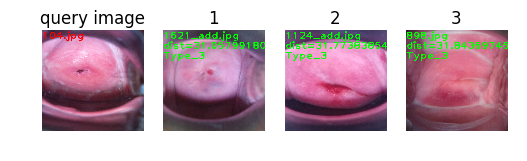

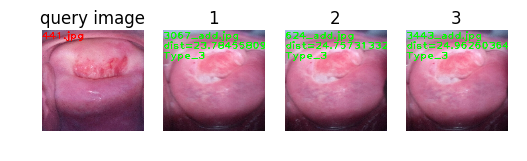

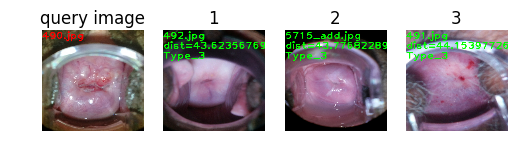

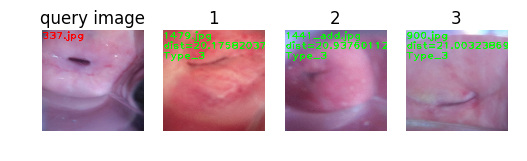

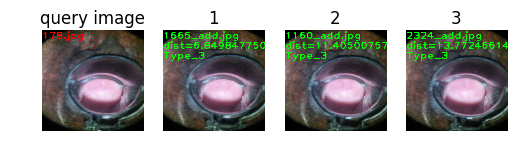

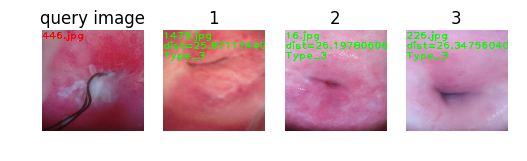

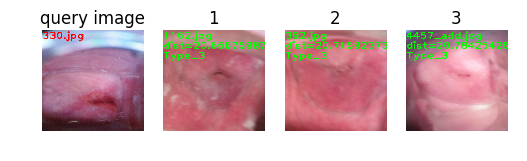

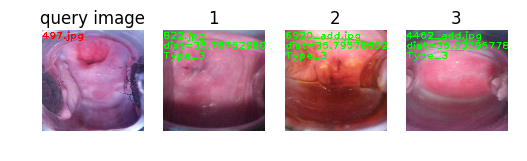

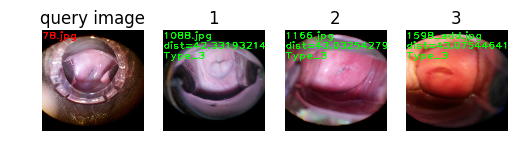

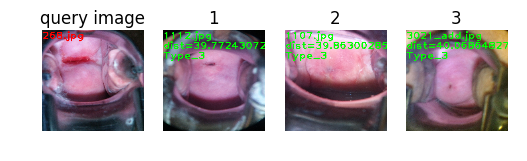

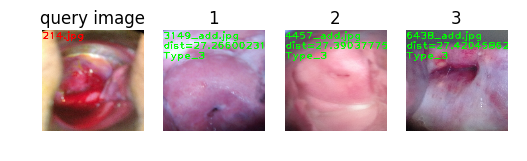

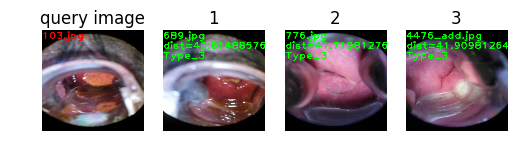

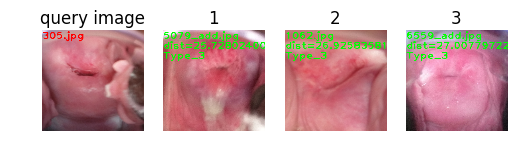

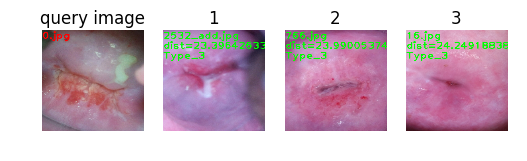

done.


In [19]:
find_duplicates()

# Wow, a lot more matches than expected!
By visual inspection of the first 30 test vectors we can see there are some **very similar** images in the training set and test set.  
On the left you will find the query images for each search followed by the top 3 matches.  
  
Some final comments:  
1. Overfitting to the leaderboard is a real risk for this dataset, Kagglers beware!  
2. This search method can also be used to remove duplicate training data.  
3. Visualizing a KNN search on your train vs. test set is an excellent way to gain insight into what your model has learned. In this case a VGG16 pretrained on ImageNet is excellent at finding visually similar images but will likely fail at classification unless fine-tuned.
  
Thank you for reading, please upvote if you found this useful!  
